In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [2]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data till just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit()

                #get forecast
                pred = pd.Series(model.forecast()).iloc[0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [3]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [4]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

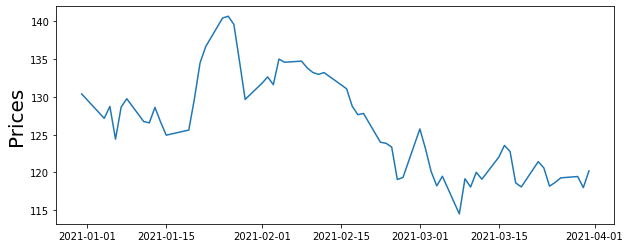

In [5]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

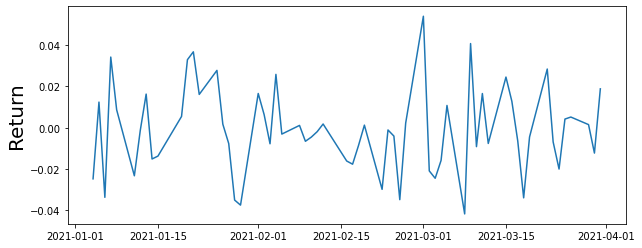

In [6]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

## ACF

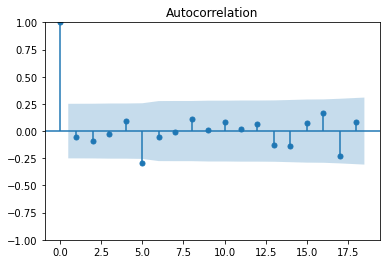

In [7]:
plot_acf(returns)
plt.show()

## PACF

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


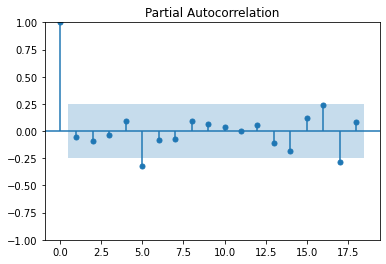

In [8]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 8332.94it/s]


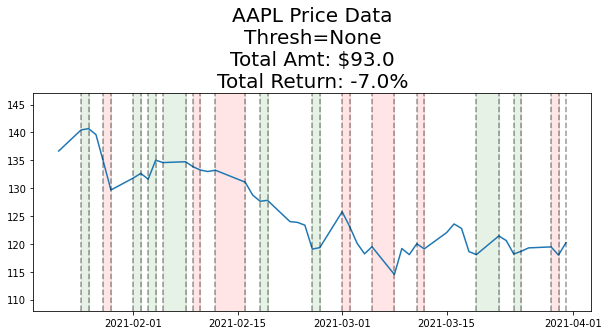

93.00203359207643

In [9]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [10]:
final_amts1 = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4717.32it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 7828.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 8052.13it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4896.72it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4342.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4698.77it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 3986.26it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4245.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 3641.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 3123.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4724.45it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 2928.37it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 5187.28it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 5062.46it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 3925.84it/s]


C:\Users\user\AppData\Local\Temp/ipykernel_18900/56435718.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts1)


Text(0.5, 1.0, 'Avg: $95.36\nSD: $6.2')

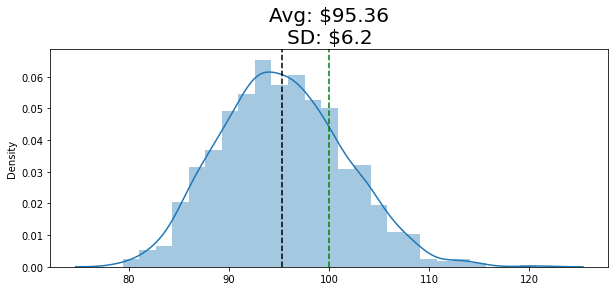

In [11]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts1)
plt.axvline(np.mean(final_amts1), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts1),2), round(np.std(final_amts1),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4586.82it/s]


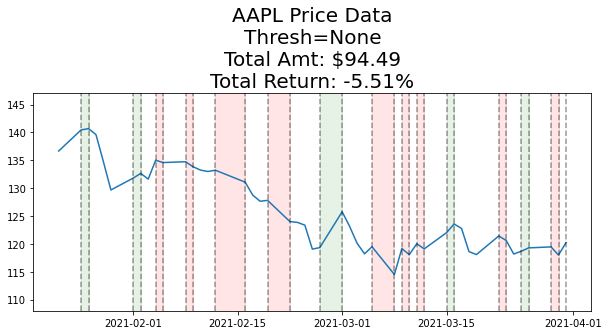

94.4932601568962

In [12]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

# Try AR(1) Model

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 17.22it/s]


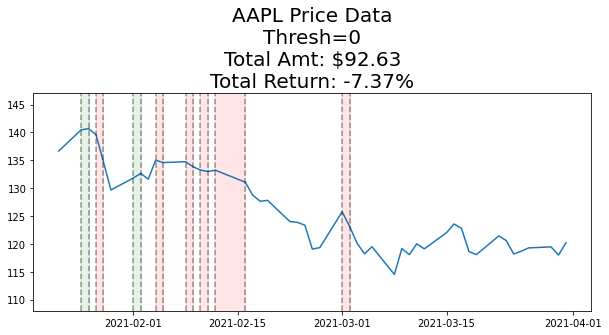

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 18.16it/s]


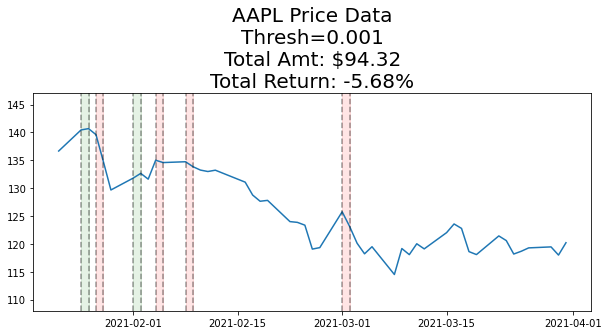

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 16.12it/s]


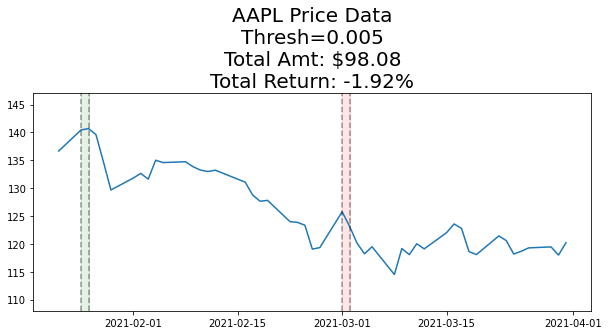

In [13]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try MA(5) Model

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▊                                                                                 | 1/47 [00:00<00:30,  1.51it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\sta

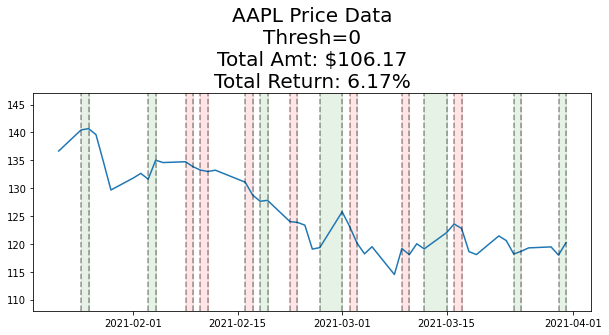

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▊                                                                                 | 1/47 [00:00<00:35,  1.28it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\sta

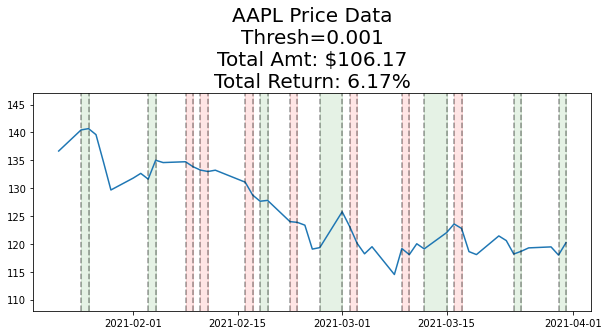

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▊                                                                                 | 1/47 [00:00<00:27,  1.67it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\sta

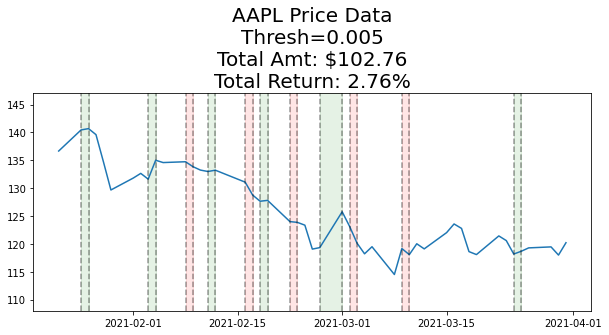

In [14]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (0,0,5), thresh, verbose=False)

# Try ARMA(5,5) Model

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▊                                                                                 | 1/47 [00:01<00:57,  1.26s/it]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|█████▎                                                     

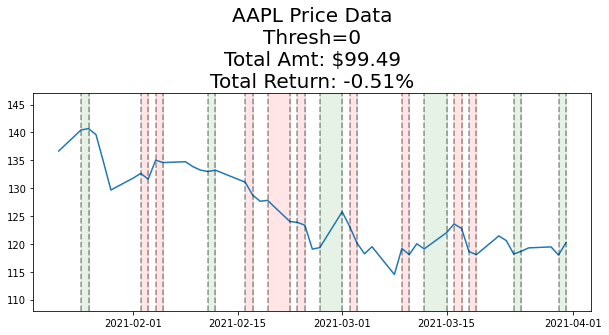

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▊                                                                                 | 1/47 [00:01<00:49,  1.07s/it]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|█████▎                                                     

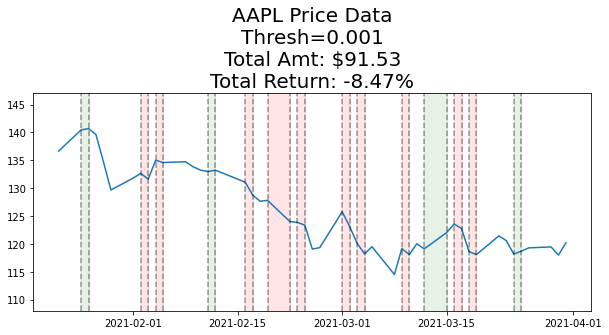

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▊                                                                                 | 1/47 [00:00<00:39,  1.16it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|█████▎                                                     

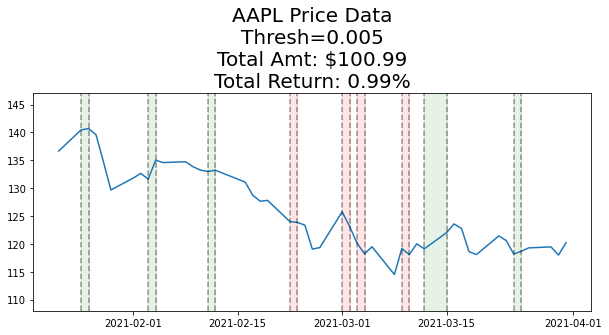

In [15]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)